In [2]:
import glob, os, sys
import uproot, ROOT
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, roc_auc_score, auc
sys.path.append("..")
from utils.utils import *
import pandas as pd

Welcome to JupyROOT 6.28/04


In [3]:
    path = "/global/u2/a/agarabag/pscratch/ditdau_samples/"
    combined_bkg = pd.read_csv(path+'inc_bdt_bkg.csv')
    combined_signal = pd.read_csv(path+'inc_bdt_signal.csv')


    class DataFrameCuts:
        def __init__(self, df_bkg, df_signal):
            self.df_bkg = df_bkg
            self.df_signal = df_signal

        def apply_cut(self, df, cut_condition):
            return df[cut_condition]

        def cut4(self, df):
            return self.apply_cut(df, ((df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 3)) | ((df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 1)))

        def cut5(self, df):
            return self.apply_cut(df, (df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 1))

        def cut6(self, df):
            return self.apply_cut(df, (df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 3))

        def cut7(self, df):
            return self.apply_cut(df, ((df['n_tracks_lead'] == 1) | (df['n_tracks_lead'] == 3)) & ((df['n_tracks_subl'] == 1) | (df['n_tracks_subl'] == 3)))

        def process(self):
            self.combined_bkg_1p3p = self.cut4(self.df_bkg)
            self.combined_bkg_1p1p = self.cut5(self.df_bkg)
            self.combined_bkg_3p3p = self.cut6(self.df_bkg)

            self.combined_signal_1p3p = self.cut4(self.df_signal)
            self.combined_signal_1p1p = self.cut5(self.df_signal)
            self.combined_signal_3p3p = self.cut6(self.df_signal)


            return {
                'bkg': {
                    '1p3p': self.combined_bkg_1p3p,
                    '1p1p': self.combined_bkg_1p1p,
                    '3p3p': self.combined_bkg_3p3p,
                    'inc': self.df_bkg
                },
                'signal': {
                    '1p3p': self.combined_signal_1p3p,
                    '1p1p': self.combined_signal_1p1p,
                    '3p3p': self.combined_signal_3p3p,
                    'inc': self.df_signal
                }
            }

    channel = ['1p3p', '1p1p', '3p3p', 'inc']
    color = ['red', 'darkorange', 'green', 'steelblue']
    
    combined_bkg = combined_bkg[combined_bkg['inc_new_bdt']>0]
    combined_signal = combined_signal[combined_signal['inc_new_bdt']>0]
 
    cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
    combined = cuts_processor.process()

    combined_bkg_1p3p = combined['bkg']['1p3p']
    combined_bkg_1p1p = combined['bkg']['1p1p']
    combined_bkg_3p3p = combined['bkg']['3p3p']
    combined_bkg_inc = combined['bkg']['inc']
    combined_signal_1p3p = combined['signal']['1p3p']
    combined_signal_1p1p = combined['signal']['1p1p']
    combined_signal_3p3p = combined['signal']['3p3p']
    combined_signal_inc = combined['signal']['inc']


    # use non trained data
    combined_bkg_1p3p = combined_bkg_1p3p[(combined_bkg_1p3p['event_id']%10) >= 7] # 30% of data
    combined_bkg_1p1p = combined_bkg_1p1p[(combined_bkg_1p1p['event_id']%10) >= 7] # 30% of data
    combined_bkg_3p3p = combined_bkg_3p3p[(combined_bkg_3p3p['event_id']%10) >= 7] # 30% of data
    combined_bkg_inc = combined_bkg_inc[(combined_bkg_inc['event_id']%10) >= 7] # 30% of data

    combined_signal_1p3p = combined_signal_1p3p[(combined_signal_1p3p['event_id']%10) >= 7] # 30% of data
    combined_signal_1p1p = combined_signal_1p1p[(combined_signal_1p1p['event_id']%10) >= 7] # 30% of data
    combined_signal_3p3p = combined_signal_3p3p[(combined_signal_3p3p['event_id']%10) >= 7] # 30% of data
    combined_signal_inc = combined_signal_inc[(combined_signal_inc['event_id']%10) >= 7] # 30% of data

    #combine singal and bkg
    combined_1p3p = pd.concat([combined_bkg_1p3p, combined_signal_1p3p])
    combined_1p1p = pd.concat([combined_bkg_1p1p, combined_signal_1p1p])
    combined_3p3p = pd.concat([combined_bkg_3p3p, combined_signal_3p3p])
    combined_inc = pd.concat([combined_bkg_inc, combined_signal_inc])
    

In [4]:
combined_1p3p

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,n_subjets,event_weight,bdt_score,bdt_score_new,average_mu,eta,pT_weight,label,weight,inc_new_bdt
11,30846038,204277.62,0,0.904852,0.615187,0.206012,0.639335,0.035230,0.073669,0.134229,...,3,3.345557e-02,0.385999,0.025324,33.500000,0.933921,0.004301,0,1.439062e-04,0.015812
26,35244399,253583.66,0,0.829664,0.837761,0.331736,0.769130,0.030560,0.033404,0.053136,...,2,9.618879e-03,0.707424,0.859147,40.500000,-0.744808,0.005332,0,5.128663e-05,0.699743
31,36300348,200720.88,0,0.847755,0.683239,0.084422,0.555999,0.014591,0.027558,0.149601,...,3,6.865749e-02,0.610205,0.434748,57.500000,0.632800,0.004301,0,2.953241e-04,0.267387
44,38037907,200515.05,0,0.831688,0.550406,0.252362,0.653424,0.015519,0.003575,0.187043,...,4,1.802877e-02,0.519883,0.226454,36.500000,1.421922,0.004301,0,7.754918e-05,0.401369
54,45574018,209212.66,0,0.855507,0.764981,0.295278,0.669263,0.003218,0.060898,0.046829,...,2,1.276485e-02,0.682694,0.561993,44.500000,1.470158,0.004301,0,5.490689e-05,0.461672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293122,41524108,271465.28,1,0.873976,0.946599,0.387725,0.817651,0.010757,0.018382,0.005579,...,2,2.144577e-10,0.687353,0.960122,32.500000,1.554225,2174.839596,1,4.664111e-07,0.949112
293126,42550537,413183.60,1,0.942900,0.857370,0.145288,0.911787,0.000000,0.010732,0.040855,...,2,2.144577e-10,0.812728,0.996759,41.499996,1.595728,1824.306013,1,3.912365e-07,0.996809
293130,30057687,565203.75,1,0.975662,0.969891,0.216918,0.943407,0.003990,0.006976,0.023174,...,2,2.144577e-10,0.755395,0.996925,27.500000,-0.428862,8224.912955,1,1.763896e-06,0.997517
293136,36104507,271426.25,1,0.844433,0.501574,0.041872,0.768851,0.000000,0.017634,0.132048,...,2,2.144577e-10,0.612932,0.035589,40.500000,1.401260,2174.839596,1,4.664111e-07,0.041379


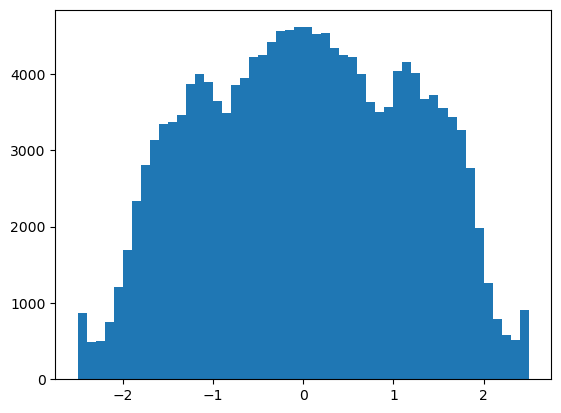

999968.8


In [13]:
plt.hist(combined_1p1p['eta'].values, bins=50)
plt.show()
print(np.max(combined_1p1p['ditau_pt'].values))

In [14]:
# save combined_1p1p scores, pt, eta to a root file 
output = ROOT.TFile("combined_1p.root", "RECREATE")
tree = ROOT.TTree("CollectionTree", "CollectionTree")
bdt_score = np.zeros(1, dtype=float)
pt = np.zeros(1, dtype=float)
eta = np.zeros(1, dtype=float)
weight = np.zeros(1, dtype=float)
tree.Branch('bdt_score', bdt_score, 'bdt_score/D')
tree.Branch('pt', pt, 'pt/D')
tree.Branch('eta', eta, 'eta/D')
#save weights
tree.Branch('weight', weight, 'weight/D')

for i in range(len(combined_1p1p)):
    pt[0] = combined_1p1p['ditau_pt'].values[i]
    eta[0] = combined_1p1p['eta'].values[i]
    bdt_score[0] = combined_1p1p['inc_new_bdt'].values[i]
    weight[0] = combined_1p1p['weight'].values[i]
    tree.Fill()

output.Write()
output.Close()

In [4]:
# use MVScoreTuner to make a root file with combined_1p1p scores, pt, eta
alg = MVScoreTuner(name="FlatScore_1p", disc=combined_1p1p['inc_new_bdt'].values, xvar=combined_1p1p['ditau_pt'].values, yvar=combined_1p1p['eta'].values, reverse=False, smooth=False, usehist=True)

In [5]:
alg.saveas("/global/homes/a/agarabag/pscratch/ditdau_samples/wp_test.alg")

[10:11:50 INFO   ]  Creating alg workspace ../../../../../homes/a/agarabag/pscratch/ditdau_samples/wp_test.alg


True

In [6]:
alg.train()

[10:11:51 INFO   ]  
[10:11:51 INFO   ]  =====>>>>>> Loki MVA Algorithm Configuration <<<<<<=====
[10:11:51 INFO   ]  Algorithm :
[10:11:51 INFO   ]    Name    : FlatScore_1p
[10:11:51 INFO   ]    Class   : MVScoreTuner
[10:11:51 INFO   ]    File    : /global/homes/a/agarabag/pscratch/ditdau_samples/wp_test.alg
[10:11:51 INFO   ]  
[10:11:51 INFO   ]  Configuration : 
[10:11:51 INFO   ]    disc                   : [0.0577839  0.26393375 0.71251518 ... 0.99699855 0.99702269 0.99671233]
[10:11:51 INFO   ]    xvar                   : [218339.4  240302.08 215281.25 ... 987340.56 213538.2  324779.03]
[10:11:51 INFO   ]    yvar                   : [-0.71796405 -2.0233514   0.7103239  ...  0.8379494  -0.36318225
 -0.824176  ]
[10:11:51 INFO   ]    reverse                : False               
[10:11:51 INFO   ]    smooth                 : False               
[10:11:51 INFO   ]    usehist                : True                
[10:11:51 INFO   ]    yvals2d                : None                

DDDDD:  [<utils.utils.WorkingPointExtractor object at 0x7f4716f9bb90>]
GGGGGGG:  [<utils.utils.Hist object at 0x7f4717000610>]
HHHHHHHH:  <utils.utils.Hist object at 0x7f4717000610>


AttributeError: 'numpy.ndarray' object has no attribute 'new_hist'